# Determining the value of automobiles

The service for the sale of used cars "Not beaten, not painted" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. You have historical data at your disposal: technical characteristics, equipment and prices of cars. You need to build a model to determine the value. 

The customer is interested in:

- quality of prediction;
- speed of prediction;
- training time.

Traits:

- DateCrawled - date when the questionnaire was downloaded from the database
- VehicleType - type of car body
- RegistrationYear - year of car registration
- Gearbox - type of gearbox
- Power - power (hp)
- Model - car model
- Kilometer - mileage (km)
- RegistrationMonth - month of vehicle registration
- FuelType - fuel type
- Brand - car brand
- Repaired - whether the car has been repaired or not.
- DateCreated - date of questionnaire creation
- NumberOfPictures - number of photos of the car
- PostalCode - postal code of the questionnaire owner (user)
- LastSeen - date of the last activity of the user

Target attribute

- Price - price (euro)

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
#from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler



In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Missing in five columns - Model, Gearbox, VehicleType, FuelType, Repaired



For convenience, we will lowercase all column names:



In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Let's look at the values in the columns with skips - the values here are categorical, the proportion of skipped values is greater than or close to 10%:

In [6]:
df.isnull().sum()/len(df)*100

datecrawled           0.000000
price                 0.000000
vehicletype          10.579368
registrationyear      0.000000
gearbox               5.596709
power                 0.000000
model                 5.560588
kilometer             0.000000
registrationmonth     0.000000
fueltype              9.282697
brand                 0.000000
repaired             20.079070
datecreated           0.000000
numberofpictures      0.000000
postalcode            0.000000
lastseen              0.000000
dtype: float64

In [7]:
df = df.fillna('unknown') 

Next, let's consider numerical features:

In [8]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Detected outliers in the columns:

- price - minimum value - zero;
- registrationyear - minimum value - 1000, maximum - 9999;
- power - minimum value - zero, maximum value - 20000, which is too much for a passenger car;
- registrationmonth - minimum value is zero, most likely a skip;
- numberofpictures - all values in the column are zeros.


Next, we will delete columns that have no value for the study - datecrawled, datecreated and lastseen, postalcode, numberofpictures(filled with zeros),registrationmonth(only the year of registration has value):

In [9]:
columns = [
    'datecrawled', 
    'datecreated', 
    'lastseen', 
    'postalcode', 
    'numberofpictures', 
    'registrationmonth']
df = df.drop(columns, axis=1)

Let's look at the distribution of values in the columns:



In [10]:
def make_hist(column, t, xl, yl):
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df[column], kde=True, bins=50)
    plt.title(t)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.show()

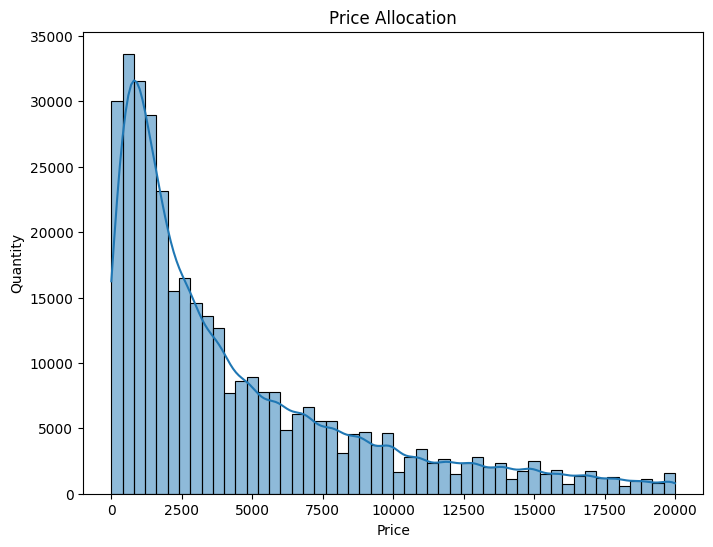

In [11]:
make_hist('price', 'Price Allocation', 'Price', 'Quantity')


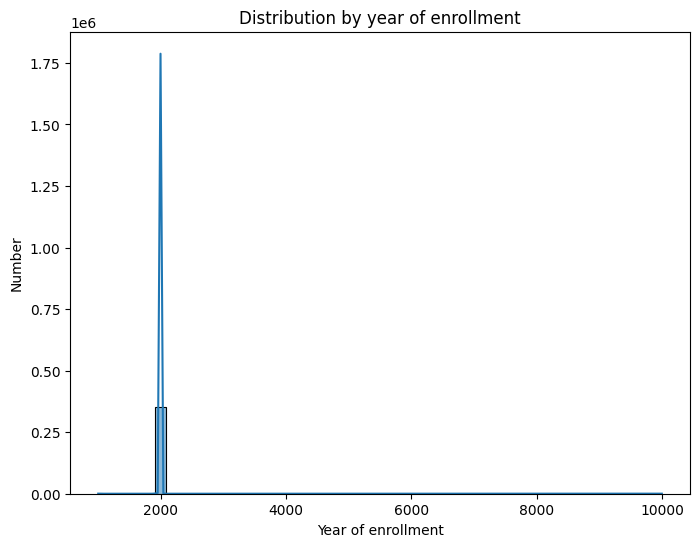

In [12]:
make_hist('registrationyear', 'Distribution by year of enrollment', 'Year of enrollment', 'Number')


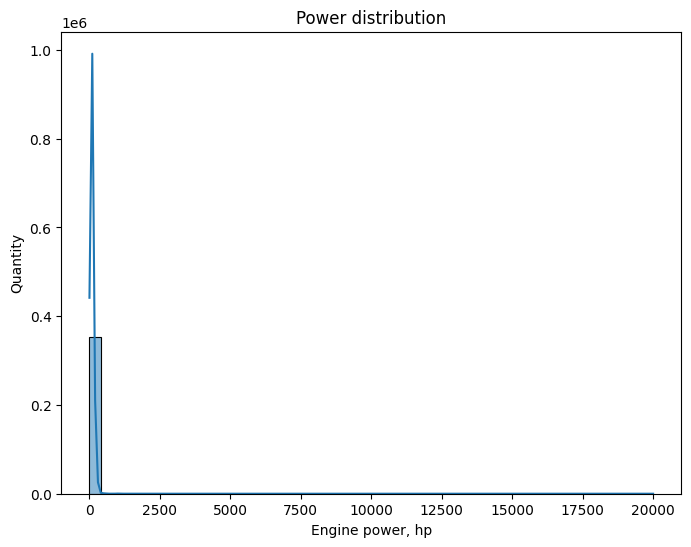

In [13]:
make_hist('power','Power distribution', 'Engine power, hp', 'Quantity')


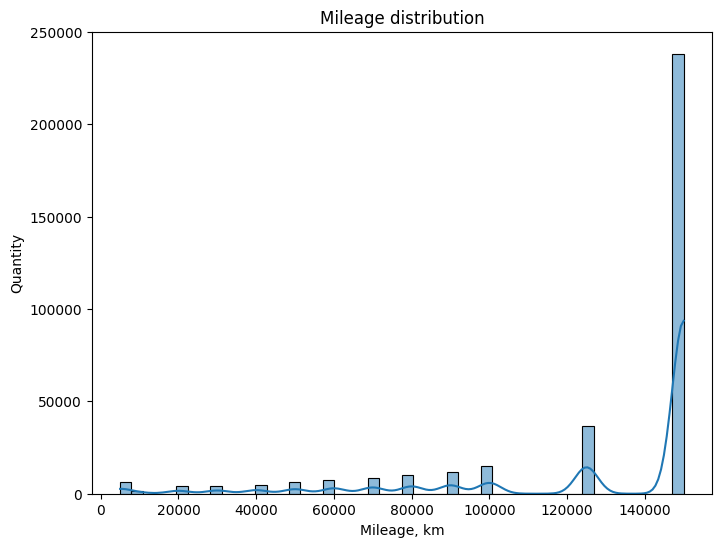

In [14]:
make_hist('kilometer', 'Mileage distribution', 'Mileage, km', 'Quantity')


The histogram shows that most of the machines have a price up to 2500 euros, we can see quite a large number of zero values:
- let's get rid of zero and too small values by removing them up to the 5th percentile, 
- eliminate the outliers - the price values are above about 13500.

In [15]:
low_price = np.percentile (df.price , 5)
df = df.query('(price <= 13500) and (price > @low_price)')

Now let's look at the power values:
- replace the zeros with the median. 
- process the values that are too large

In [16]:
df.loc[(df['power'] > 1000) & (df['power'] <= 10000), 'power'] = df['power'] / 10
df.loc[(df['power'] > 10000), 'power'] = df['power'] / 100
df.loc[df['power'] == 0, 'power'] = df['power'].median()

In the column with the year of car registration
- let's remove the abnormal values: 
    - we leave the minimum year of manufacture at 1900  
    - maximum 2016:

In [17]:
df = df.query('(registrationyear >= 1950) and (registrationyear <= 2016)')


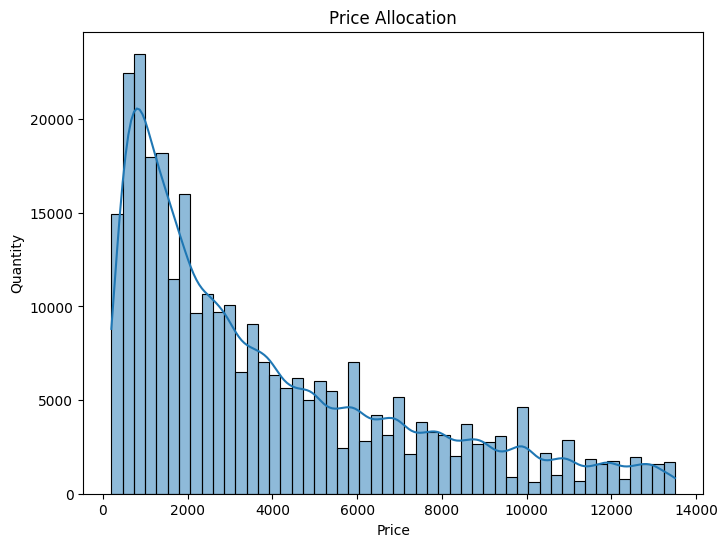

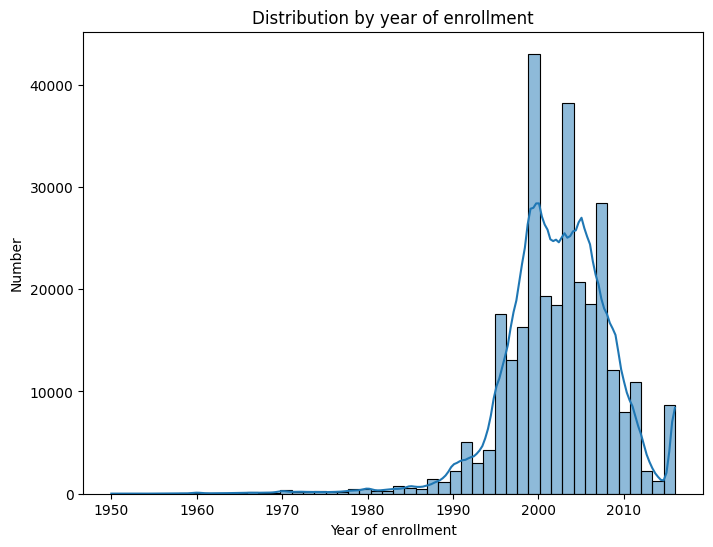

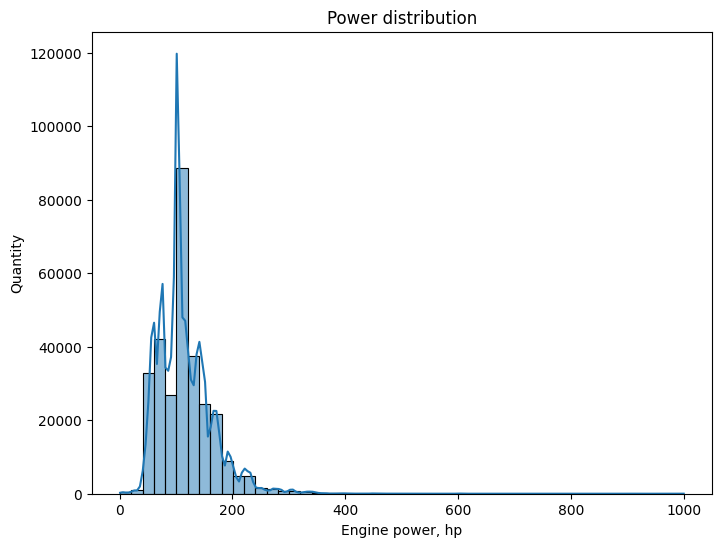

In [18]:
make_hist('price', 'Price Allocation', 'Price', 'Quantity')
make_hist('registrationyear', 'Distribution by year of enrollment', 'Year of enrollment', 'Number')
make_hist('power','Power distribution', 'Engine power, hp', 'Quantity')



Using a heat map, let's look at the relationship of features with a small number of unique values - fueltype, repaired, gearbox:

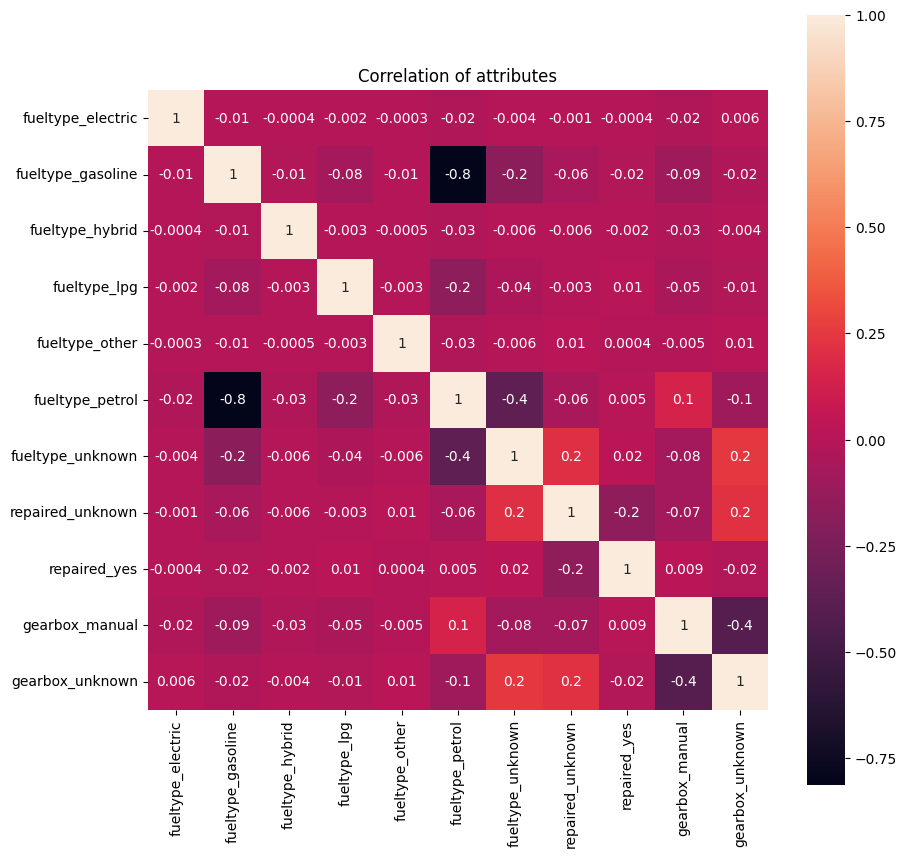

In [19]:
categorial_tmp = ['fueltype', 'repaired', 'gearbox']

df_tmp = pd.get_dummies(df[categorial_tmp], drop_first=True)

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_tmp.corr(),annot = True, fmt = '.1g', ax=ax, square=True)
plt.title('Correlation of attributes')
plt.show() 

The target attribute is most influenced by: year of registration, power, and fuel type gasoline, as well as mileage.

We also see a strong inverse correlation between the types of fuel petrol and gasoline, which is essentially the same type of fuel - gasoline.

As a result of data preprocessing:

- we got rid of anomalous values and omissions in the data;
- removed columns unnecessary for the study;
- built histograms of the distribution of features;
- built a hitmap demonstrating the relationship between the attributes.

## Model training

Let's divide the initial data into training and test samples

In [41]:
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=12345)


In [42]:
df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=12345)


Define features:

In [43]:
features_test = df_test.drop(['price'], axis=1)
target_test = df_test['price']

features_train = df_train.drop(['price'], axis=1)
target_train = df_train['price']

features_val = df_val.drop(['price'], axis=1)
target_val = df_val['price']


In [44]:
categorial = ['fueltype', 'repaired', 'gearbox', 'vehicletype', 'brand', 'model']

encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(features_train[categorial])

cat_train = pd.DataFrame(encoder_ohe.transform(features_train[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names(),
                                   index=features_train.index)
cat_test = pd.DataFrame(encoder_ohe.transform(features_test[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names(),
                                   index=features_test.index)

features_train_ohe = features_train.copy()
features_train_ohe.drop(categorial, axis=1, inplace=True)
features_train_ohe = features_train_ohe.join(cat_train)

features_test_ohe = features_test.copy()
features_test_ohe.drop(categorial, axis=1, inplace=True)
features_test_ohe = features_test_ohe.join(cat_test)

Let's do some feature scaling:

In [45]:
numeric = ['power', 'kilometer', 'registrationyear']

scaler = StandardScaler()
scaler.fit(df_train[numeric])
features_train_ohe[numeric] = scaler.transform(df_train[numeric])
features_test_ohe[numeric] = scaler.transform(df_test[numeric])


pd.options.mode.chained_assignment = None
features_train_ohe.head(3)

,registrationyear,power,kilometer,x0_cng,x0_electric,x0_gasoline,x0_hybrid,x0_lpg,x0_other,x0_petrol,...,x5_wrangler,x5_x_reihe,x5_x_trail,x5_x_type,x5_xc_reihe,x5_yaris,x5_yeti,x5_ypsilon,x5_z_reihe,x5_zafira
121695,2.129835,-0.271493,0.546467,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320516,-0.202203,0.816757,0.546467,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32312,-0.046734,-0.209894,0.546467,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [47]:
def get_model_stat(model, features_train, target_train, features_test, target_test):
    """
    function takes a model, returns RMSE, time of fit and time of prediction
    """
    curr_time = time.time()
    model.fit(features_train, target_train)
    fit_time = round((time.time() - curr_time), 3)
    curr_time = time.time()
    predicted_test = model.predict(features_test)

    predict_time = round((time.time() - curr_time), 3)
    rmse = round(mean_squared_error(target_test, predicted_test)**0.5, 3)
    
    return [rmse, fit_time, predict_time]


In [53]:
def get_model_stat_grid(model, params, features_train, target_train, features_test, target_test):
    curr_time = time.time()
    grid = GridSearchCV(model, param_grid = params, cv=5,
                                            scoring = RMSE_score, n_jobs=-1)
    grid.fit(features_train,target_train)
    fit_time = round((time.time() - curr_time), 3)
    curr_time = time.time()
    predicted_test = grid.predict(features_test)
    predict_time = round((time.time() - curr_time), 3)
    rmse = round(mean_squared_error(target_test, predicted_test)**0.5, 3)
    best_params = grid.best_params_

    
    return [rmse, fit_time, predict_time, best_params] 

#### Linear Regression

In [27]:
model = LinearRegression()

linear = get_model_stat(model, features_train_ohe, target_train, features_test_ohe, target_test)

print('RMSE:', linear[0])
print('Время обучения:', linear[1])
print('Время предсказания:', linear[2])

RMSE: 2055.965
Время обучения: 88.711
Время предсказания: 0.226


#### Decision Tree

In [28]:
model = DecisionTreeRegressor(max_depth=11, random_state=12345, min_samples_leaf=8, min_samples_split=8)

tree = get_model_stat(model, features_train_ohe, target_train, features_test_ohe, target_test)

print('RMSE:', tree[0])
print('Время обучения:', tree[1])
print('Время предсказания:', tree[2])


RMSE: 1562.106
Время обучения: 6.217
Время предсказания: 0.061


#### Random Forest

In [64]:
ce_ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
ce_ord.fit(features_train[categorial])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[categorial] = ce_ord.transform(features_train[categorial])
features_test_ord[categorial] = ce_ord.transform(features_test[categorial])

features_val[categorial] = ce_ord.transform(features_val[categorial])


In [65]:
numeric = ['power', 'kilometer', 'registrationyear']

scaler = StandardScaler()
scaler.fit(df_train[numeric])
features_train_ord[numeric] = scaler.transform(df_train[numeric])
features_test_ord[numeric] = scaler.transform(df_test[numeric])
features_val[numeric] = scaler.transform(features_val[numeric])

pd.options.mode.chained_assignment = None
features_train_ohe.head(3)

,registrationyear,power,kilometer,x0_cng,x0_electric,x0_gasoline,x0_hybrid,x0_lpg,x0_other,x0_petrol,...,x5_wrangler,x5_x_reihe,x5_x_trail,x5_x_type,x5_xc_reihe,x5_yaris,x5_yeti,x5_ypsilon,x5_z_reihe,x5_zafira
121695,2.129835,-0.271493,0.546467,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320516,-0.202203,0.816757,0.546467,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32312,-0.046734,-0.209894,0.546467,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
model = RandomForestRegressor(n_estimators=70, max_depth=13, random_state=12345, min_samples_leaf=2, min_samples_split=6)
forestregressor_params = {'n_estimators':range(10, 51, 10),
             'max_depth':range (1,10)}

forest = get_model_stat_grid(model, forestregressor_params, features_train_ord, target_train, features_test_ord, target_test)

print('RMSE:', forest[0])
print('Время обучения:', forest[1])
print('Время предсказания:', forest[2])


RMSE: 1577.404
Время обучения: 1001.204
Время предсказания: 0.209


#### LightGBM

In [54]:
lgbm_params = {
    'n_estimators': [10,50,100],
    'max_depth': [15,30],
    'num_leaves': [10,20,31],
    'learning_rate': [0.1]
}


model = LGBMRegressor(random_state=12345)
light = get_model_stat_grid(model, lgbm_params, features_train_ord, target_train, features_test_ord, target_test)

print('RMSE:', light[0])
print('Время обучения:', light[1])
print('Время предсказания:', light[2])

RMSE: 1362.324
Время обучения: 12708.486
Время предсказания: 0.302


#### CatBoost

In [35]:
catboost_params = {
    'learning_rate': [0.1],
    'iterations': [10,50,100],
    'max_depth': [10,20]
}

catboost_model = CatBoostRegressor(random_state=12345, verbose=100)
boost = get_model_stat_grid(catboost_model, catboost_params, features_train_ord, target_train, features_test_ord, target_test)

print('RMSE:', boost[0])
print('Время обучения:', boost[1])
print('Время предсказания:', boost[2])

0:	learn: 3102.1303267	total: 120ms	remaining: 1.08s
9:	learn: 2011.2845959	total: 654ms	remaining: 0us
0:	learn: 3094.8621973	total: 51.9ms	remaining: 467ms
9:	learn: 2004.4539577	total: 572ms	remaining: 0us
0:	learn: 3102.5799135	total: 50.9ms	remaining: 458ms
9:	learn: 2008.5963278	total: 530ms	remaining: 0us
0:	learn: 3099.3189429	total: 76.4ms	remaining: 688ms
9:	learn: 2009.3956951	total: 591ms	remaining: 0us
0:	learn: 3089.6526838	total: 57.8ms	remaining: 520ms
9:	learn: 1998.5434341	total: 564ms	remaining: 0us


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 3102.1303267	total: 73.8ms	remaining: 3.62s
49:	learn: 1429.4655137	total: 2.93s	remaining: 0us
0:	learn: 3094.8621973	total: 54.5ms	remaining: 2.67s
49:	learn: 1428.1471166	total: 2.68s	remaining: 0us
0:	learn: 3102.5799135	total: 64.4ms	remaining: 3.15s
49:	learn: 1426.8981125	total: 3.11s	remaining: 0us
0:	learn: 3099.3189429	total: 45.3ms	remaining: 2.22s
49:	learn: 1429.0437775	total: 2.97s	remaining: 0us
0:	learn: 3089.6526838	total: 55.9ms	remaining: 2.74s
49:	learn: 1420.9488456	total: 2.8s	remaining: 0us


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 3102.1303267	total: 53.5ms	remaining: 5.3s
99:	learn: 1348.3725387	total: 5.79s	remaining: 0us
0:	learn: 3094.8621973	total: 82.5ms	remaining: 8.16s
99:	learn: 1348.6239543	total: 6.41s	remaining: 0us
0:	learn: 3102.5799135	total: 80.9ms	remaining: 8.01s
99:	learn: 1346.2408137	total: 5.79s	remaining: 0us
0:	learn: 3099.3189429	total: 78.4ms	remaining: 7.76s
99:	learn: 1347.6125881	total: 6.11s	remaining: 0us
0:	learn: 3089.6526838	total: 62.8ms	remaining: 6.22s
99:	learn: 1338.5047234	total: 6.15s	remaining: 0us


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 3097.1703414	total: 105ms	remaining: 10.3s
99:	learn: 1346.4851176	total: 7.22s	remaining: 0us
RMSE: 1379.475
Время обучения: 73.64
Время предсказания: 0.025


## Model Analysis

In [38]:
results = pd.DataFrame([
    linear,
    tree,
    forest,
    light,
    boost], 
    columns=['RMSE', 'Время обучения', 'Время предсказания'],
    index=['LinearRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'CatBoost'])


In [39]:
results.sort_values(by='RMSE')


,RMSE,Время обучения,Время предсказания
LightGBM,1378.826,3987.075,0.482
CatBoost,1379.475,73.640,0.025
DecisionTree,1562.106,6.217,0.061
RandomForest,1577.404,1001.204,0.209
LinearRegression,2055.965,88.711,0.226


According to the results of the study we can conclude that the best models for solving the problem are LightGBM and CatBoost.

Decision tree model shows the best result in terms of learning and prediction speed, but loses in terms of quality, however, it meets the specified value of RMSE < 2500.

The linear regression model shows the worst value, but falls within the given RMSE value.

Thus, if the accuracy of the model is more important to the customer, then **the best solution is LightGBM**. If the speed of training and prediction is more important, a simpler solving tree model will do. 


## Testing the best model

In [60]:
light[3]

{'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100, 'num_leaves': 31}

In [94]:
best_model = LGBMRegressor(**{'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100, 'num_leaves': 31, 'random_state':12345})

In [93]:
best_model.fit(features_train_ord, 
                                target_train,)
y_pred = best_model.predict(features_val)

rmse = round(mean_squared_error(target_val, y_pred)**0.5, 3)
print('Validation RMSE: ', rmse)

Validation RMSE:  1392.045
